In [5]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import math
import random

### Creating the original function and the target function

In [7]:
def f(x):
    return 1/(x**2 - 3*x + 2)

def target_func_rational(params, x_data, y_data):
    a, b, c, d = params
    numerator = a*x_data + b
    denominator = x_data**2 + c*x_data + d
    if np.any(np.abs(denominator) < 1e-10):
        return 1e10
    F_x = numerator / denominator
    residuals = F_x - y_data
    return np.sum(residuals**2)

This is another way of target function via loss-function in order to compate two tipes of optimisation algorithms

In [10]:
def F(x_data, a, b, c, d):
    return (a*x_data + b) / (x_data**2 + c*x_data + d)
    
# Loss function with penalty to avoid denominator near zero
def loss(params, x_data, y_data, lambda_pen=10.0, eta=1e-6):
    a, b, c, d = params
    denominator = x_data**2 + c*x_data + d
    
    # Main residual
    fit = F(x_data, a, b, c, d)
    residual = fit - y_data
    sq_error = np.sum(residual**2)
    
    # Penalty for denominator close to zero
    penalty = lambda_pen * np.sum(1.0 / (denominator**2 + eta))
    
    # Additional penalty if denominator has real roots in [0, 3]
    discriminant = c**2 - 4*d
    if discriminant >= 0:
        root1 = (-c - np.sqrt(discriminant)) / 2
        root2 = (-c + np.sqrt(discriminant)) / 2
        # Penalize if roots are in the data range [0, 3]
        if (0 <= root1 <= 3) or (0 <= root2 <= 3):
            penalty += 1000 * (discriminant + 1)
    
    return sq_error + penalty

### Generating the noisy data

In [14]:
np.random.seed(123)
k_values = np.arange(0, 1001)
x_k = 3 * k_values / 1000
f_xk = f(x_k)
delta_k = np.random.normal(0, 1, len(x_k))

y_k = np.zeros_like(x_k)
for i in range(len(x_k)):
    if f_xk[i] < -100:
        y_k[i] = -100 + delta_k[i]
    elif f_xk[i] > 100:
        y_k[i] = 100 + delta_k[i]
    else:
        y_k[i] = f_xk[i] + delta_k[i]


### Levenberg-Marquardt algorithm for rational optimisation

 a_best= 0.001541, b_best = 0.251716, c_best= -3.000005, d_best = 2.000503, f-calculations = 27, iterations = 27


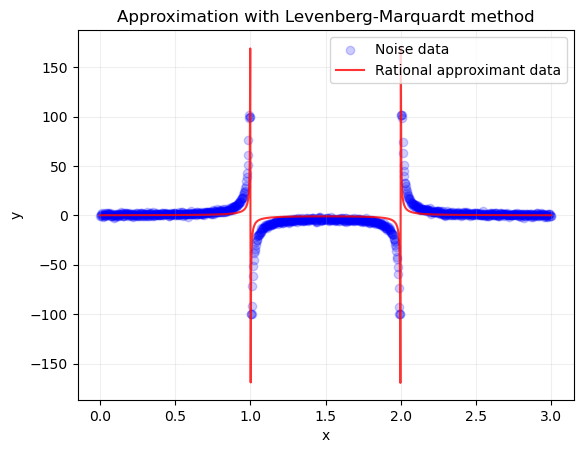

In [17]:
def jacobian_rational(params, x_data, y_data):

    a, b, c, d = params
    n = len(x_data)
    J = np.zeros((n, 4)) 
    denominator = x_data**2 + c * x_data + d
    denominator_sq = denominator**2

    if np.any(np.abs(denominator) < 1e-10):
        return np.ones((n, 4)) * 1e5

    J[:, 0] = x_data / denominator
    J[:, 1] = 1 / denominator
    numerator_val = a * x_data + b
    J[:, 2] = -numerator_val * x_data / denominator_sq
    J[:, 3] = -numerator_val / denominator_sq
    
    return J

def residuals_rational(params, x_data, y_data):

    a, b, c, d = params
    numerator = a * x_data + b
    denominator = x_data**2 + c * x_data + d
    
    if np.any(np.abs(denominator) < 1e-10):
        return np.ones_like(x_data) * 1e5
    
    F_x = numerator / denominator
    return F_x - y_data

def levenberg_marquardt(target_func, initial_params, x_data, y_data, jacobian_func=None):

    if target_func == target_func_rational:
        def residuals(params):
            return residuals_rational(params, x_data, y_data)
        
        if jacobian_func is None:
            def jacobian(params):
                return jacobian_rational(params, x_data, y_data)
        else:
            jacobian = jacobian_func
    else:
        raise ValueError("Unsupported target function type")
    
    try:
        result = scipy.optimize.least_squares(
            fun=residuals,
            x0=initial_params,
            jac=jacobian,
            method='lm', 
            xtol=1e-8, 
            ftol=1e-8,   
            gtol=1e-8,  
            max_nfev=2000, 
            verbose=0      
        )
        
        optimized_params = result.x
        success = result.success
        message = result.message
        nfev = result.nfev 
        njev = result.njev
        cost = result.cost 
        
        return {
            'params': optimized_params,
            'success': success,
            'message': message,
            'nfev': nfev,
            'njev': njev,
            'cost': cost,
            'iterations': nfev, 
            'f_calculations': nfev
        }
        
    except Exception as e:
        print(f"Error: {e}")
        
        try:
            result = scipy.optimize.least_squares(
                fun=residuals,
                x0=initial_params,
                method='lm',
                xtol=1e-6,
                ftol=1e-6,
                max_nfev=1000
            )
            
            optimized_params = result.x
            success = result.success
            message = result.message
            nfev = result.nfev
            
            return {
                'params': optimized_params,
                'success': success,
                'message': message,
                'nfev': nfev,
                'njev': 0,
                'cost': result.cost,
                'iterations': nfev,
                'f_calculations': nfev
            }
            
        except Exception as e2:
            print(f"Alternative error: {e2}")
            return None

result_rational_lm = levenberg_marquardt(target_func_rational, [0.0, 1.0, -3.0, 2.0], x_k, y_k)

if result_rational_lm is not None:
    a_opt, b_opt, c_opt, d_opt = result_rational_lm['params']
    print(f" a_best= {a_opt:.6f}, b_best = {b_opt:.6f}, c_best= {c_opt:.6f}, d_best = {d_opt:.6f}, f-calculations = {result_rational_lm['f_calculations']}, iterations = {result_rational_lm['iterations']}")

plt.figure()
plt.scatter(x_k,y_k, color='blue', alpha=0.2, label='Noise data')
plt.grid(alpha=0.2)
y_r_lm = (a_opt*x_k + b_opt)/(x_k**2 + c_opt*x_k + d_opt)
plt.plot(x_k, y_r_lm, 'r-', alpha=0.8, label='Rational approximant data')
plt.xlabel('x')
plt.ylabel('y')
plt.title ('Approximation with Levenberg-Marquardt method')
plt.legend()
plt.show()

Here we can see good approximation but we have two critical points in (1) and (2) - the roots of denominator.
The corfficients are almost as the original ones.

### The Nelder-Mead algorithm
This method uses rational target function without restrictions on critical points. Because of that in the graph we can see the emissions in roots-points.


The coefficients is almost as the original ones. However, the number of f-calculations and iterations is much higher than that of algorithm Levenberg-Marquardt.

 a_best= 0.000298, b_best = -0.000111, c_best= -3.008993, d_best = 2.014011, f-calculations = 1024, iterations = 496


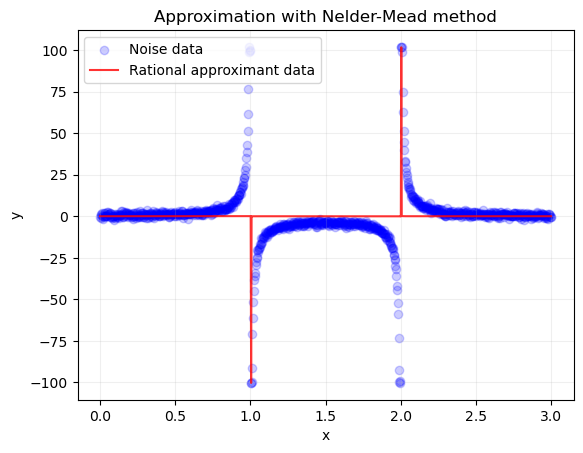

In [213]:
def nelder_mead(target_func, x0, x_data, y_data):

    options = {
        'disp': False,
        'maxiter': 5000,
        'maxfev': 10000,
        'xatol': 1e-8,
        'fatol': 1e-8,
        'adaptive': True 
    }
    
    try:
        # Пробуем оптимизацию с ограничениями
        result = scipy.optimize.minimize(
            target_func, 
            x0, 
            args=(x_data, y_data),
            method='Nelder-Mead',
            options=options
        )
    
    except Exception as e:
        print(f"Error: {e}")
        result = scipy.optimize.minimize(
            target_func, 
            x0, 
            args=(x_data, y_data),
            method='Nelder-Mead',
            options={'disp': False}
        )

    return {
        'params': result.x, 
        'success': result.success,
        'message': result.message,
        'f_opt': result.fun, 
        'f_calculations': result.nfev, 
        'iterations': result.nit, 
        'cost': result.fun 
    }

result_rational_nm = nelder_mead(target_func_rational, [0.0, 0.0, -2.95, 2.05], x_k, y_k)
if result_rational_nm is not None:
    a_opt_nm, b_opt_nm, c_opt_nm, d_opt_nm = result_rational_nm['params']
    print(f" a_best= {a_opt_nm:.6f}, b_best = {b_opt_nm:.6f}, c_best= {c_opt_nm:.6f}, d_best = {d_opt_nm:.6f}, f-calculations = {result_rational_nm['f_calculations']}, iterations = {result_rational_nm['iterations']}")

plt.figure()
plt.scatter(x_k,y_k, color='blue', alpha=0.2, label='Noise data')
plt.grid(alpha=0.2)
y_r_nm = (a_opt_nm*x_k + b_opt_nm)/(x_k**2 + c_opt_nm*x_k + d_opt_nm)
plt.plot(x_k, y_r_nm, 'r-', alpha=0.8, label='Rational approximant data')
plt.xlabel('x')
plt.ylabel('y')
plt.title ('Approximation with Nelder-Mead method')
plt.legend()
plt.show()

Here is the second variation of Nelder-Mead algorithm but via loss-function with restrictions on critical points. In these points the approximation function skips roots and does not creat the emissions. But this approcsimation is not represenative enough in the graph.

Nevertheless, the coefficients are alse close to the original. But the number of calculations increases, so ершы indicates the inefficiency of this method.

 a_best= -0.000677, b_best = 0.000413, c_best= -3.564000, d_best = 1.865641, f-calculations = 10000, iterations = 3314


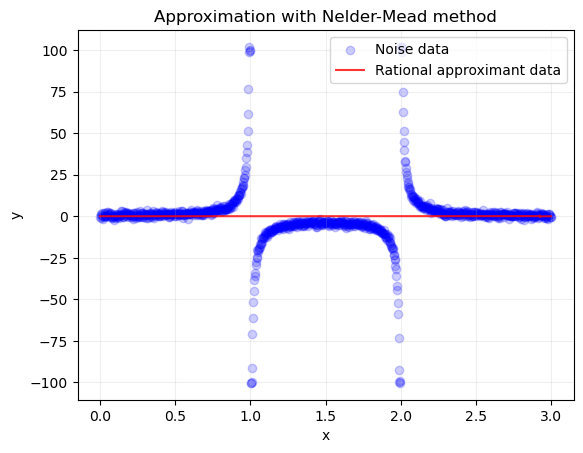

In [189]:
result_rational_nm = nelder_mead(loss, [0.0, 0.0, -2.95, 2.05], x_k, y_k)
if result_rational_nm is not None:
    a_opt_nm, b_opt_nm, c_opt_nm, d_opt_nm = result_rational_nm['params']
    print(f" a_best= {a_opt_nm:.6f}, b_best = {b_opt_nm:.6f}, c_best= {c_opt_nm:.6f}, d_best = {d_opt_nm:.6f}, f-calculations = {result_rational_nm['f_calculations']}, iterations = {result_rational_nm['iterations']}")

plt.figure()
plt.scatter(x_k,y_k, color='blue', alpha=0.2, label='Noise data')
plt.grid(alpha=0.2)
y_r_nm = (a_opt_nm*x_k + b_opt_nm)/(x_k**2 + c_opt_nm*x_k + d_opt_nm)
plt.plot(x_k, y_r_nm, 'r-', alpha=0.8, label='Rational approximant data')
plt.xlabel('x')
plt.ylabel('y')
plt.title ('Approximation with Nelder-Mead method')
plt.legend()
plt.show()

### The simulating annealing

 a_best= -0.100000, b_best = 0.305015, c_best= -3.162071, d_best = 2.162651, f-calculations = 10476, iterations = 1000


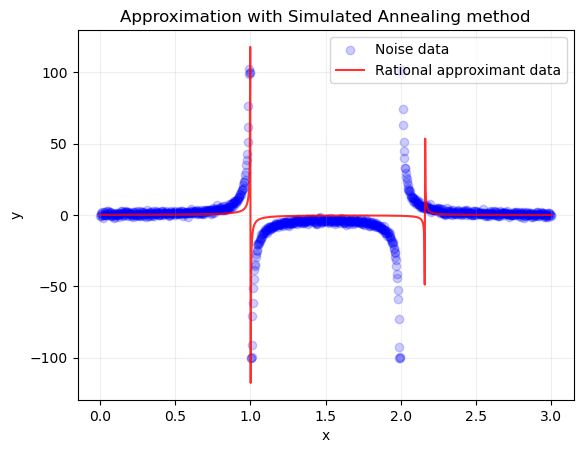

In [109]:
def simulated_annealing(target_func, x0, x_data, y_data, bounds, T_start, maxiter, random_state=None):

    if random_state is not None:
        np.random.seed(random_state)

    if bounds is None:
        bounds = [(-0.1, 0.1), (-0.5, 0.5), (-3.5, -3.1), (1.8, 2.2)]

    def scipy_target(params):
        return target_func(params, x_data, y_data)

    result = scipy.optimize.dual_annealing(
        scipy_target,
        bounds=bounds,
        maxiter=maxiter,
        initial_temp=T_start,
        restart_temp_ratio=1e-8,
        visit=2.62, 
        accept=-5.0, 
        no_local_search=False, 
        seed=random_state
    )
    
    return {
        'params': result.x,
        'cost': result.fun,
        'f_calculations': result.nfev,
        'iterations': result.nit,
        'success': result.success,
        'message': result.message
    }

result_rational_sa = simulated_annealing(target_func_rational, [0.01, 0.99, -2.99, 2.01], x_k, y_k, bounds=[(-0.1, 0.1), (-0.5, 0.5), (-3.5, -3.1), (1.8, 2.2)], T_start=100.0, maxiter=1000, random_state=None)
if result_rational_sa is not None:
    a_opt_sa, b_opt_sa, c_opt_sa, d_opt_sa = result_rational_sa['params']
    print(f" a_best= {a_opt_sa:.6f}, b_best = {b_opt_sa:.6f}, c_best= {c_opt_sa:.6f}, d_best = {d_opt_sa:.6f}, f-calculations = {result_rational_sa['f_calculations']}, iterations = {result_rational_sa['iterations']}")

plt.figure()
plt.scatter(x_k,y_k, color='blue', alpha=0.2, label='Noise data')
plt.grid(alpha=0.2)
y_r_sa = (a_opt_sa*x_k + b_opt_sa)/(x_k**2 + c_opt_sa*x_k + d_opt_sa)
plt.plot(x_k, y_r_sa, 'r-', alpha=0.8, label='Rational approximant data')
plt.xlabel('x')
plt.ylabel('y')
plt.title ('Approximation with Simulated Annealing method')
plt.legend()
plt.show()

Firstly, the recieved coefficients are close to the original ones. The number of f-calculations and iterations is commensurate with the resultes of Nelder-Mead algorithm.

The graph has visible critical points near the roots.

### The Differential evolution algorithm 
This is the first method via the rational target function without restrictions on critical points. 

In the result the recieved coefficients are not quite like the original ones and the graph has only one critical point. It can be connected with the interval for bounds.

 a_best= -0.529307, b_best = 0.529418, c_best= -2.000170, d_best = 1.000175, f-calculations = 1435, iterations = 4


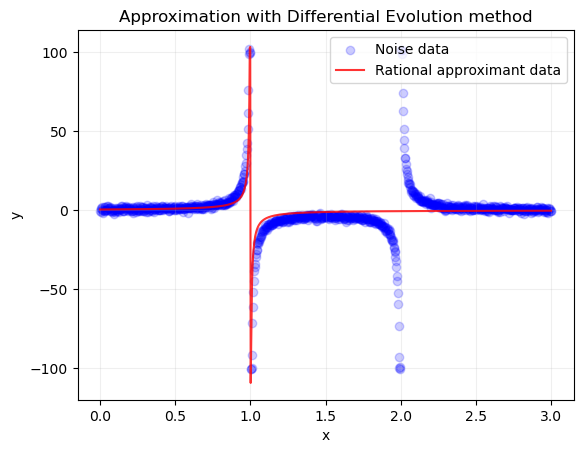

In [19]:
def differential_evolution_optimization(target_func, x_data, y_data, bounds=None, popsize=15, maxiter=1000, random_state=None):

    if bounds is None:
        bounds = [(-5, 5), (-5, 5), (-10, 0), (0, 10)]

    def de_target(params):
        return target_func(params, x_data, y_data)
    
    try:

        result = scipy.optimize.differential_evolution(
            de_target,
            bounds=bounds,
            strategy='best1bin',
            maxiter=maxiter,
            popsize=popsize,
            seed=random_state,
            disp=False,
            polish=True  
        )
        
        return {
            'params': result.x,
            'cost': result.fun,
            'f_calculations': result.nfev,
            'iterations': result.nit,
            'success': result.success,
            'message': result.message
        }
        
    except Exception as e:
        print(f"Error: {e}")
        return None


result_rational_de = differential_evolution_optimization(target_func_rational, x_k, y_k, bounds=[(-5, 5), (-5, 5), (-5, 5), (-5, 5)],
    popsize=20,maxiter=100,random_state=42)

if result_rational_de is not None:
    a_opt_de, b_opt_de, c_opt_de, d_opt_de = result_rational_de['params']
    print(f" a_best= {a_opt_de:.6f}, b_best = {b_opt_de:.6f}, c_best= {c_opt_de:.6f}, d_best = {d_opt_de:.6f}, f-calculations = {result_rational_de['f_calculations']}, iterations = {result_rational_de['iterations']}")

plt.figure()
plt.scatter(x_k,y_k, color='blue', alpha=0.2, label='Noise data')
plt.grid(alpha=0.2)
y_r_de = (a_opt_de*x_k + b_opt_de)/(x_k**2 + c_opt_de*x_k + d_opt_de)
plt.plot(x_k, y_r_de, 'r-', alpha=0.8, label='Rational approximant data')
plt.xlabel('x')
plt.ylabel('y')
plt.title ('Approximation with Differential Evolution method')
plt.legend()
plt.show()

This is the second method via the loss function with restrictions on critical points.

However, unlike the Nelder-Mead algorithm in this case the recieved coefficient are the worst as a graph, which is not representative.

 a_best= -5.000000, b_best = 2.646457, c_best= 1.145148, d_best = 3.902750, f-calculations = 540, iterations = 5


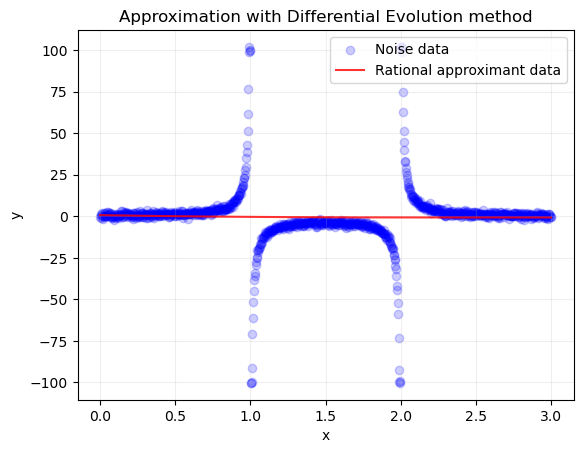

In [193]:
result_rational_de = differential_evolution_optimization(loss, x_k, y_k, bounds=[(-5, 5), (-5, 5), (-5, 5), (-5, 5)],
    popsize=20,maxiter=100,random_state=42)

if result_rational_de is not None:
    a_opt_de, b_opt_de, c_opt_de, d_opt_de = result_rational_de['params']
    print(f" a_best= {a_opt_de:.6f}, b_best = {b_opt_de:.6f}, c_best= {c_opt_de:.6f}, d_best = {d_opt_de:.6f}, f-calculations = {result_rational_de['f_calculations']}, iterations = {result_rational_de['iterations']}")

plt.figure()
plt.scatter(x_k,y_k, color='blue', alpha=0.2, label='Noise data')
plt.grid(alpha=0.2)
y_r_de = (a_opt_de*x_k + b_opt_de)/(x_k**2 + c_opt_de*x_k + d_opt_de)
plt.plot(x_k, y_r_de, 'r-', alpha=0.8, label='Rational approximant data')
plt.xlabel('x')
plt.ylabel('y')
plt.title ('Approximation with Differential Evolution method')
plt.legend()
plt.show()

### Creating the data about 15 cities coordinates

In [22]:
cities_data = """
Aachen               -57.0   28.0
Augsburg              54.0  -65.0
Braunschweig          46.0   79.0
Bremen                 8.0  111.0
Essen                -36.0   52.0
Freiburg             -22.0  -76.0
Hamburg               34.0  129.0
Hof                   74.0    6.0
Karlsruhe             -6.0  -41.0
Kassel                21.0   45.0
Kiel                  37.0  155.0
Koeln                -38.0   35.0
Mannheim              -5.0  -24.0
Muenchen              70.0  -74.0
Nuernberg             59.0  -26.0
"""

coordinates = {}
lines = cities_data.strip().split('\n')
for line in lines:
    parts = line.strip().split()
    x = float(parts[-2])
    y = float(parts[-1])
    coordinates[parts[0]]=[x,y]

### Calculating the matrix of distances

In [25]:
def calculate_distance_matrix(coordinates, distance_type='euclidean'):

    n = len(coordinates)
    dist_matrix = np.zeros((n, n))
    city_list = list(coordinates.keys())
    
    for i in range(n):
        for j in range(n):
            city_i = city_list[i]
            city_j = city_list[j]
            x1, y1 = coordinates[city_i]
            x2, y2 = coordinates[city_j]
            
            if distance_type == 'euclidean':
                dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            elif distance_type == 'manhattan':
                dist = abs(x2 - x1) + abs(y2 - y1)
            else:
                raise ValueError("Unknown dist")
            dist_matrix[i][j] = dist
    
    return dist_matrix

dist_matrix = calculate_distance_matrix(coordinates, distance_type='euclidean')

The solvation of the corresponding Travelling Salesman Problem.

Here we save the firs path to compare it with the best one.

In [28]:
def total_distance(route, dist_matrix):

    total = 0
    for i in range(len(route) - 1):
        total += dist_matrix[route[i]][route[i + 1]]
    total += dist_matrix[route[-1]][route[0]]
    return total

def simulated_annealing_tsp(dist_matrix, city_names, temp=10000, cooling_rate=0.995, iterations=5000):

    n = len(dist_matrix)

    current_route = list(range(n))
    random.shuffle(current_route)
    current_cost = total_distance(current_route, dist_matrix)
    
    best_route = current_route[:]
    best_cost = current_cost

    first_route = current_route[:]
    first_cost = current_cost
        
    for i in range(iterations):
        new_route = current_route[:]
        a, b = random.sample(range(n), 2)
        new_route[a], new_route[b] = new_route[b], new_route[a]
        new_cost = total_distance(new_route, dist_matrix)

        cost_diff = new_cost - current_cost

        if cost_diff < 0 or random.random() < np.exp(-cost_diff / temp):
            current_route, current_cost = new_route, new_cost

            if new_cost < best_cost:
                best_route, best_cost = new_route[:], new_cost
        temp *= cooling_rate
    
    print(f"Best Route (indexes): {best_route}")

    best_route_names = None
    if city_names:
        best_route_names = [city_names[i] for i in best_route]
        print(f"Best Route (Cities): {' -> '.join(best_route_names)}")
    
    print(f"Best Length: {best_cost:.2f}")

    return best_route, best_cost, first_route, first_cost, best_route_names


Here is the visualisation of the routes with indexes of the cities and the cities names

Best Route (indexes): [2, 7, 14, 13, 1, 5, 8, 12, 0, 11, 4, 9, 3, 10, 6]
Best Route (Cities): Braunschweig -> Hof -> Nuernberg -> Muenchen -> Augsburg -> Freiburg -> Karlsruhe -> Mannheim -> Aachen -> Koeln -> Essen -> Kassel -> Bremen -> Kiel -> Hamburg
Best Length: 679.32


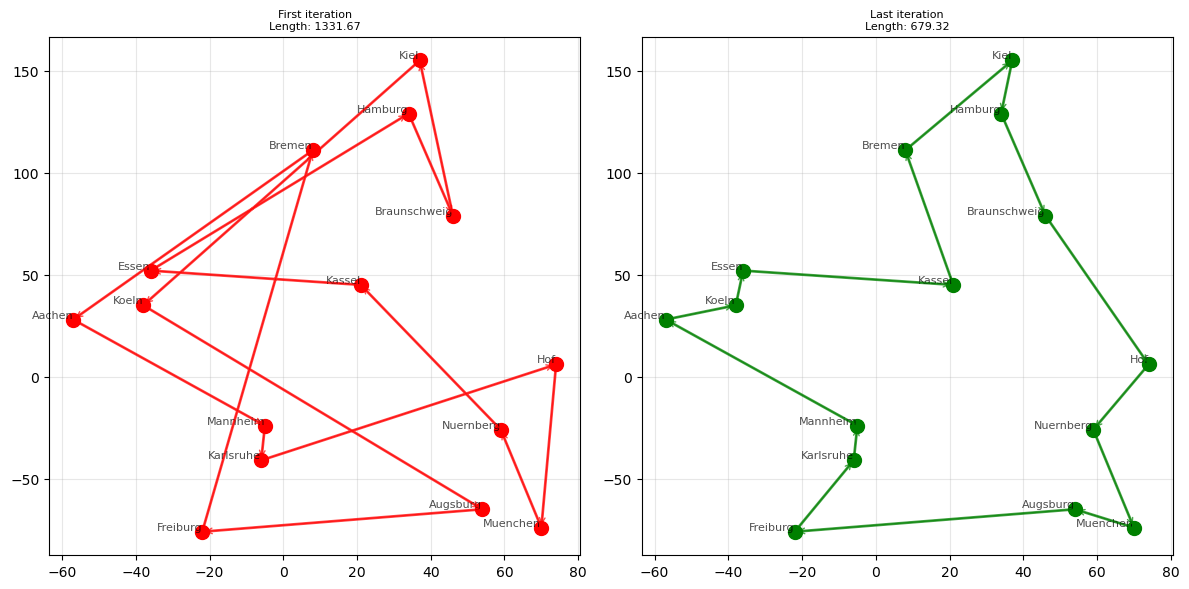

In [31]:
def visualize_iterations(coordinates, first_route, best_route, city_names, first_cost, best_cost):

    coords_list = [coordinates[name] for name in city_names]
    x_coords = [coord[0] for coord in coords_list]
    y_coords = [coord[1] for coord in coords_list]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    visualize_single_route(ax1, first_route, x_coords, y_coords, city_names, 
                          first_cost, "First iteration", "red")

    visualize_single_route(ax2, best_route, x_coords, y_coords, city_names, 
                          best_cost, "Last iteration", "green")
    
    plt.tight_layout()
    plt.show()

def visualize_single_route(ax, route, x_coords, y_coords, city_names, cost, title, color):

    try:
        route_x = [x_coords[i] for i in route] + [x_coords[route[0]]]
        route_y = [y_coords[i] for i in route] + [y_coords[route[0]]]

        ax.plot(route_x, route_y, 'o-', markersize=8, linewidth=2, color=color, alpha=0.7)
        ax.set_title(f'{title}\nLength: {cost:.2f}', fontsize=8)
        ax.grid(True, alpha=0.3)

        for idx, city_idx in enumerate(route):
            if city_idx < len(x_coords):  # Проверка на валидность индекса
                x, y = x_coords[city_idx], y_coords[city_idx]
                ax.text(x, y, f'{city_names[city_idx]}', fontsize=8, 
                        ha='right', va='bottom', 
                        alpha=0.7)
                ax.plot(x, y, 'o', markersize=10, color=color)

        for i in range(len(route)):
            start_idx = route[i]
            end_idx = route[(i + 1) % len(route)]
            
            if start_idx < len(x_coords) and end_idx < len(x_coords):  # Проверка индексов
                start_x, start_y = x_coords[start_idx], y_coords[start_idx]
                end_x, end_y = x_coords[end_idx], y_coords[end_idx]

                mid_x = (start_x + end_x) / 2
                mid_y = (start_y + end_y) / 2
                ax.annotate('', xy=(end_x, end_y), xytext=(start_x, start_y), arrowprops=dict(arrowstyle='->', color=color, lw=1, alpha=0.7))
    
    except Exception as e:
        print(f"Error: {e}")
        ax.text(0.5, 0.5, f'Error:\n{e}', 
                transform=ax.transAxes, ha='center', va='center',
                alpha=0.7)

best_route, best_cost, first_route, first_cost, best_route_names = simulated_annealing_tsp(
        dist_matrix, list(coordinates.keys()), temp=10000, cooling_rate=0.995, iterations=5000
    )

visualize_iterations(coordinates, first_route, best_route, 
                               list(coordinates.keys()), first_cost, best_cost)